In [115]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine,text
from scipy import stats
import plotly.express as px
import toml
import psrc_theme
import geopandas as gpd
import plotly.express as px

%matplotlib inline
from IPython.display import display, HTML

# to show plotly figures in quarto HTML file
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
pio.templates.default = "simple_white+psrc_color" # set plotly template

input_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'input_configuration.toml'))
valid_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'validation_configuration.toml'))

# create connection
conn = create_engine('sqlite:///../../../../inputs/db/'+input_config['db_name'])

# summary data location
csv_path = os.path.join(valid_config['model_dir'], 'outputs/validation')

# table format
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

## transit boarding

### boarding by mode

In [116]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_mode.csv')).sort_values('observed_boardings', ascending=False)
table_df = df.copy()

table_df.loc['Total','observed_boardings'] = table_df['observed_boardings'].sum(axis=0)
table_df.loc['Total','model_boardings'] = table_df['model_boardings'].sum(axis=0)
table_df.loc['Total','mode'] = 'Total'
table_df['diff'] = table_df['model_boardings']-table_df['observed_boardings']
table_df['perc_diff'] = table_df['diff']/table_df['observed_boardings']
table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
table_df = table_df.reset_index()
table_df

,index,mode,observed_boardings,model_boardings,diff,perc_diff
0,0,b,"332,640.45","358,741.89","26,101.43",7.85%
1,4,r,"81,991.16","89,964.62","7,973.45",9.72%
2,2,f,"11,349.85","9,066.93","-2,282.92",-20.11%
3,1,c,"6,354.00","7,020.67",666.67,10.49%
4,3,p,"3,235.36","2,980.79",-254.58,-7.87%
5,Total,Total,"435,570.83","467,774.89","32,204.06",7.39%


In [117]:
df_boarding_line = pd.read_csv(os.path.join(csv_path,'daily_boardings_by_line.csv'), index_col='description')
df_boarding_line[['observed_boardings','model_boardings']] = df_boarding_line[['observed_boardings','model_boardings']].astype('float')

df_mode = df_boarding_line[df_boarding_line['route_code'].isin([6996,6999,6998])].reset_index()

df_mode['submode'] = df_mode['mode'].map({"r": "Link Red Line", "c": "Sounder"})
df_mode = df_mode[['submode','model_boardings']].copy()
df_mode = df_mode.groupby('submode')['model_boardings'].sum().reset_index()

df_obs = pd.read_sql(text("SELECT * FROM observed_transit_agency_boardings"), con=conn.connect())
df_obs_mode = df_obs.copy()
df_obs_mode['boardings'] = df_obs_mode['boardings'].astype(float)
df_obs_mode = df_obs_mode[df_obs_mode['submode'].isin(["Link","Sounder"])].copy()
df_obs_mode['submode'] = df_obs_mode['submode'].map({"Link": "Link Red Line", "Sounder": "Sounder"})

df_obs_mode = df_obs_mode.groupby(['submode','year'])['boardings'].sum().unstack().reset_index()
df_obs_mode = df_obs_mode.rename(columns={2023:'2023 boarding', 2024:'2024 boarding'})
df_mode = df_obs_mode.merge(df_mode, on='submode')

df_mode['2023 % diff'] = (df_mode['model_boardings']-df_mode['2023 boarding'])/df_mode['2023 boarding']
df_mode['2024 % diff'] = (df_mode['model_boardings']-df_mode['2024 boarding'])/df_mode['2024 boarding']
df_mode[['2023 % diff']] = df_mode[['2023 % diff']].applymap(format_percent)
df_mode[['2024 % diff']] = df_mode[['2024 % diff']].applymap(format_percent)

df_mode

,submode,2023 boarding,2024 boarding,model_boardings,2023 % diff,2024 % diff
0,Link Red Line,"78,765.00","91,203.00","86,505.92",9.83%,-5.15%
1,Sounder,"6,765.00","7,711.00","7,020.67",3.78%,-8.95%


### boarding by agency

In [118]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_agency.csv')).sort_values('observed_boardings', ascending=False)
plot_df = df.melt(id_vars=['agency'], value_vars=['observed_boardings', 'model_boardings'],
                  var_name='source', value_name='count')

In [119]:
table_df = df.copy()

table_df.loc['Total','observed_boardings'] = table_df.sum(axis=0).observed_boardings
table_df.loc['Total','model_boardings'] = table_df.sum(axis=0).model_boardings
table_df.loc['Total','agency'] = 'Total'
table_df['diff'] = table_df['model_boardings']-table_df['observed_boardings']
table_df['perc_diff'] = table_df['diff']/table_df['observed_boardings']
table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
table_df = table_df.reset_index()
table_df

,index,agency,observed_boardings,model_boardings,diff,perc_diff
0,2,King County Metro,"253,313.62","268,204.45","14,890.83",5.88%
1,5,Sound Transit,"113,374.00","137,007.62","23,633.62",20.85%
2,0,Community Transit,"25,962.00","27,258.31","1,296.31",4.99%
3,4,Pierce Transit,"21,185.00","13,777.16","-7,407.84",-34.97%
4,6,Washington Ferries,"9,278.21","5,628.86","-3,649.35",-39.33%
5,3,Kitsap Transit,"8,258.00","11,172.21","2,914.21",35.29%
6,1,Everett Transit,"4,201.00","4,705.74",504.74,12.01%
7,Total,Total,"435,571.83","467,754.36","32,182.53",7.39%


In [120]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_agency.csv'), usecols=['agency', 'model_boardings']).sort_values('model_boardings', ascending=False)
df_obs = pd.read_sql(text("SELECT * FROM observed_transit_agency_boardings"), con=conn.connect())

df_obs_agency = df_obs.copy()
df_obs_agency['boardings'] = df_obs_agency['boardings'].astype(float)
df_obs_agency = df_obs_agency.groupby(['agency','year'])['boardings'].sum().unstack().reset_index()
df_obs_agency = df_obs_agency.rename(columns={2023:'2023 boarding', 2024:'2024 boarding'})
df_agency = df_obs_agency.merge(df, on='agency')

df_agency['2023 % diff'] = (df_agency['model_boardings']-df_agency['2023 boarding'])/df_agency['2023 boarding']
df_agency['2024 % diff'] = (df_agency['model_boardings']-df_agency['2024 boarding'])/df_agency['2024 boarding']
df_agency[['2023 % diff']] = df_agency[['2023 % diff']].applymap(format_percent)
df_agency[['2024 % diff']] = df_agency[['2024 % diff']].applymap(format_percent)
df_agency = df_agency.replace('inf%', '-')

df_agency

,agency,2023 boarding,2024 boarding,model_boardings,2023 % diff,2024 % diff
0,Community Transit,"23,000.00",0.00,"27,258.31",18.51%,-
1,Everett Transit,0.00,0.00,"4,705.74",-,-
2,King County Metro,"244,306.00","272,556.00","268,204.45",9.78%,-1.60%
3,Kitsap Transit,"8,000.00","9,300.00","11,172.21",39.65%,20.13%
4,Pierce Transit,"19,974.00",0.00,"13,777.16",-31.02%,-
5,Sound Transit,"115,516.00","133,703.00","137,007.62",18.60%,2.47%
6,Washington Ferries,0.00,0.00,"5,628.86",-,-


In [121]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_line.csv')).sort_values('observed_boardings', ascending=False)
df
df = df[df['mode'].isin(['b'])]
df = df.groupby(['agency']).sum()[['observed_boardings','model_boardings']]
df['difference'] = df['model_boardings']-df['observed_boardings']
df['percent diff'] = (df['difference']/df['observed_boardings'])
df[['percent diff']] = df[['percent diff']].applymap(format_percent)
df

# table_df.loc['Total','observed_boardings'] = table_df.sum(axis=0).observed_boardings
# table_df.loc['Total','model_boardings'] = table_df.sum(axis=0).model_boardings
# table_df.loc['Total','agency'] = 'Total'
# table_df['diff'] = table_df['model_boardings']-table_df['observed_boardings']
# table_df['perc_diff'] = table_df['diff']/table_df['observed_boardings']
# table_df[['observed_boardings','model_boardings','diff']] = table_df[['observed_boardings','model_boardings','diff']].astype('float')
# table_df[['perc_diff']] = table_df[['perc_diff']].applymap(format_percent)
# table_df = table_df.reset_index()
# table_df

,observed_boardings,model_boardings,difference,percent diff
agency,,,,
Community Transit,"25,962.00","27,258.31","1,296.31",4.99%
Everett Transit,"4,201.00","4,705.74",504.74,12.01%
King County Metro,"251,166.45","265,869.10","14,702.65",5.85%
Kitsap Transit,"4,048.00","5,477.29","1,429.29",35.31%
Pierce Transit,"21,185.00","13,777.16","-7,407.84",-34.97%
Sound Transit,"26,079.00","41,633.75","15,554.75",59.64%


### boarding by key route

In [122]:
# df_boarding_key = pd.read_csv(os.path.join(csv_path,'daily_boardings_key_routes.csv'), index_col='description')
# # df_boarding_key[['observed_boardings','model_boardings']] = df_boarding_key[['observed_boardings','model_boardings']].astype('float')
# # df = df_boarding_key[df_boarding_key['route_code'].isin([4200,4201,4203,4204,5001,5002,5003,5004,5005,5006,5007,1973,1975])].reset_index()
# # df.drop(['route_code','agency'], axis=1, inplace=True)
# # df
# df_boarding_key
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_line.csv'))
df = df[df['mode'].isin(['f','p'])][['description','mode','observed_boardings','model_boardings','diff','perc_diff']]
df

,description,mode,observed_boardings,model_boardings,diff,perc_diff
147,973 W Sea Water Taxi,p,759.00,363.54,-395.46,-0.52
148,975 Vashn Water Taxi,f,338.00,360.39,22.39,0.07
270,Seattle-Bremerton FF,f,"1,913.00","3,695.83","1,782.83",0.93
271,Brem-Pt Orchard FF,p,768.00,"1,045.48",277.48,0.36
272,Brem-Annapolis FF,p,469.00,233.58,-235.42,-0.50
273,Seattle-Kingston FF,p,429.00,88.33,-340.67,-0.79
274,Seattle-Southwrth FF,f,631.00,631.71,0.71,0.00
278,WSF Edmonds-Kingston,f,"1,500.13",201.74,"-1,298.39",-0.87
279,WSF Seattle-Bain Isl,f,"5,513.69","3,829.53","-1,684.17",-0.31
280,WSF Seattle-Brem,f,"1,188.97",179.78,"-1,009.19",-0.85


In [123]:
df_boarding_key = pd.read_csv(os.path.join(csv_path,'daily_boardings_key_routes.csv'), index_col='description')
df_boarding_key[['observed_boardings','model_boardings']] = df_boarding_key[['observed_boardings','model_boardings']].astype('float')

df = df_boarding_key[df_boarding_key['route_code'].isin([4200,4201,4203,4204,5001,5002,5003,5004,5005,5006,5007,1973,1975])].reset_index()
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table

,description,observed_boardings,model_boardings,diff,perc_diff


In [124]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

In [125]:
# df = pd.read_csv(os.path.join(csv_path,'bike_ferry_boardings.csv')).sort_values('@bvol', ascending=False)
# df['route_code'] = df['route_code'].astype('int')
# df[['route_code','description', '@bvol']]

In [126]:
df = df_boarding_key[df_boarding_key['route_code'].isin([6996,6999,6998])].reset_index()
df['description'] = df['route_code'].map({6998: 'Sounder South', 6999: 'Sounder North',6996: 'Link Red Line'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)

df_table

,description,observed_boardings,model_boardings,diff,perc_diff
0,Sounder South,"6,038.00","7,017.47",979.47,16.22%
1,Sounder North,316.00,3.20,-312.80,-98.99%


r^2 : 1.0


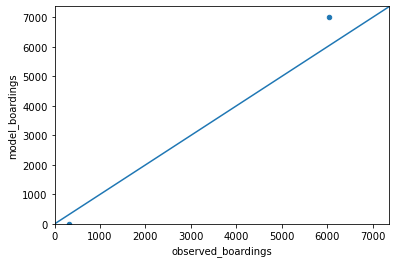

In [127]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings','model_boardings']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'],df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

In [128]:
df = df_boarding_key[df_boarding_key['route_code'].isin([1671,1672,1673,1674,1675,1676,6550,1007,1040,1997,1998])].reset_index()
df['description'] = df['route_code'].map({1671: 'A Line RapidRide', 1672: 'B Line RapidRide',
                                            1673: 'C Line RapidRide', 1674: 'D Line RapidRide',
                                            1675: 'E Line RapidRide', 1676: 'F Line RapidRide',
                                            6550: 'Sound Transit 550', 1040: 'KC Metro 40', 1007: 'KC Metro 7',
                                            1997: 'SLU Streetcar', 1998: 'First Hill Streetcar'})
df.drop(['route_code','agency'], axis=1, inplace=True)

df_table = df.copy()
df_table[['perc_diff']] = df_table[['perc_diff']].applymap(format_percent)
df_table.sort_values('model_boardings', ascending=False)

,description,observed_boardings,model_boardings,diff,perc_diff
4,E Line RapidRide,"11,426.00","14,658.52","3,232.52",28.29%
2,C Line RapidRide,"7,250.00","10,056.75","2,806.75",38.71%
3,D Line RapidRide,"9,044.00","7,332.42","-1,711.58",-18.93%
0,A Line RapidRide,"8,412.00","6,356.19","-2,055.81",-24.44%
1,B Line RapidRide,"4,177.00","3,299.96",-877.04,-21.00%


r^2 : 0.8315758237277817


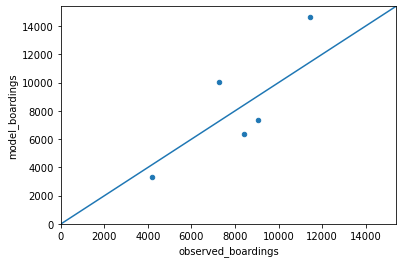

In [129]:
if len(df) > 0:
    ax = df.plot(kind='scatter', x='observed_boardings', y='model_boardings')
    lim = df[['observed_boardings', 'model_boardings']].max().max() * 1.05
    ax.set_ylim(0, lim)
    ax.set_xlim(0, lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed_boardings'], df['model_boardings'])
    print('r^2 ' + str('') + ': ' + str(r_value))

### Top routes by agency

In [130]:
df = pd.read_csv(os.path.join(csv_path, 'daily_boardings_by_line.csv'))
# df_top = pd.DataFrame()
# for agency in df['agency'].unique():
#     _df = df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(8)
#     df_top = pd.concat([df_top, _df])
# df = df_top[['agency','description','mode','model_boardings','observed_boardings','diff','perc_diff']]
cols=['agency','description','mode','model_boardings','observed_boardings','diff','perc_diff']

In [131]:
agency = 'King County Metro'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
130,King County Metro,E-Line,b,"14,658.52","11,426.00","3,232.52",0.28
5,King County Metro,7 Rain Bch-ColC-CBD,b,"11,032.94","9,954.00","1,078.94",0.11
128,King County Metro,C Line,b,"10,056.75","7,250.00","2,806.75",0.39
28,King County Metro,40 Ngt-Bal-Fre-CBD,b,"8,169.24","7,208.00",961.24,0.13
129,King County Metro,D Line,b,"7,332.42","9,044.00","-1,711.58",-0.19
132,King County Metro,H-Line,b,"6,971.95","6,907.00",64.95,0.01
67,King County Metro,160 Aub-Kent-Rent,b,"6,596.30","5,058.00","1,538.30",0.30
126,King County Metro,A Line,b,"6,356.19","8,412.00","-2,055.81",-0.24
39,King County Metro,62 SndPt-GLk-Fre-CBD,b,"6,144.35","5,899.00",245.35,0.04
43,King County Metro,70 Udst-Elake-CBD,b,"5,863.69","4,189.00","1,674.69",0.40


In [132]:
agency = 'Sound Transit'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
309,Sound Transit,Light Rail Ang Lk-NG,r,"86,505.92","79,522.00","6,983.92",0.09
293,Sound Transit,550 Bellevue-Seattle,b,"7,079.87","3,351.00","3,728.87",1.11
310,Sound Transit,Commutr Rail Tac-Sea,c,"7,017.47","6,038.00",979.47,0.16
286,Sound Transit,512 Everett-Northgte,b,"5,043.23","2,251.00","2,792.23",1.24
292,Sound Transit,545 Redmond-Seattle,b,"4,837.63","3,340.00","1,497.63",0.45
288,Sound Transit,522 Woodinvl-Roosvlt,b,"4,802.12","1,736.00","3,066.12",1.77
294,Sound Transit,554 Issaquah-Seattle,b,"4,127.82","2,153.00","1,974.82",0.92
300,Sound Transit,578 Seattle-Puyallup,b,"2,824.57","1,460.00","1,364.57",0.93
298,Sound Transit,574 Lakewood-SeaTac,b,"2,157.51","1,848.00",309.51,0.17
296,Sound Transit,560 W Sea-Bellevue,b,"2,120.33","1,227.00",893.33,0.73


In [133]:
agency = 'Community Transit'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
230,Community Transit,Swift Blue,b,"6,122.17","3,804.00","2,318.17",0.61
231,Community Transit,Swift Green,b,"2,499.82","3,000.00",-500.18,-0.17
200,Community Transit,116 Edm-Silver Firs,b,"2,127.29",955.00,"1,172.29",1.23
199,Community Transit,115 McClm P&R-AurVil,b,"1,631.61","1,133.00",498.61,0.44
206,Community Transit,202 Smokey Pt-Lynnwd,b,"1,476.64","1,002.00",474.64,0.47
205,Community Transit,201 Smokey Pt-Lynnwd,b,"1,464.01","1,049.00",415.01,0.40
191,Community Transit,101 Mar P&R-Aur Vill,b,"1,394.74",945.00,449.74,0.48
203,Community Transit,130 Edmonds-Lynnwood,b,940.72,618.00,322.72,0.52
198,Community Transit,113 Mukilteo-Lynn TC,b,810.63,802.00,8.63,0.01
195,Community Transit,109 Ash Wy P&R-LkStv,b,723.16,249.00,474.16,1.90


In [134]:
agency = 'Pierce Transit'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
160,Pierce Transit,1 6th Ave-Pac Ave,b,"1,635.30","3,035.00","-1,399.70",-0.46
185,Pierce Transit,402 Meridian,b,"1,123.89",626.00,497.89,0.80
161,Pierce Transit,2 S 19th-Bridgeport,b,"1,059.00","1,729.00",-670.00,-0.39
184,Pierce Transit,400 Puyllp-Tacoma,b,915.83,336.00,579.83,1.73
189,Pierce Transit,500 Federal Way,b,902.47,845.00,57.47,0.07
190,Pierce Transit,501 Miltn-Fed Way,b,818.50,431.00,387.50,0.90
162,Pierce Transit,3 Lakewood-Tacoma,b,802.48,"1,250.00",-447.52,-0.36
169,Pierce Transit,41 S 56th St-Salish,b,648.83,"1,088.00",-439.17,-0.40
163,Pierce Transit,4 Lakewd-South Hill,b,636.08,968.00,-331.92,-0.34
172,Pierce Transit,48 Sheridan-M St,b,495.20,"1,065.00",-569.80,-0.54


In [135]:
agency = 'Kitsap Transit'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
270,Kitsap Transit,Seattle-Bremerton FF,f,"3,695.83","1,913.00","1,782.83",0.93
271,Kitsap Transit,Brem-Pt Orchard FF,p,"1,045.48",768.00,277.48,0.36
244,Kitsap Transit,217 Brem-Silverdle E,b,877.42,417.00,460.42,1.10
242,Kitsap Transit,212 Brem-Silverdle W,b,693.61,679.00,14.61,0.02
274,Kitsap Transit,Seattle-Southwrth FF,f,631.71,631.00,0.71,0.00
259,Kitsap Transit,86 Southwrth Shuttle,b,593.04,91.00,502.04,5.52
260,Kitsap Transit,390 Poulsbo-Bainbrdg,b,467.48,170.00,297.48,1.75
243,Kitsap Transit,215 McWilliams,b,295.58,115.00,180.58,1.57
240,Kitsap Transit,8 Bethel,b,235.23,152.00,83.23,0.55
272,Kitsap Transit,Brem-Annapolis FF,p,233.58,469.00,-235.42,-0.50


In [136]:
agency = 'Everett Transit'
df[df['agency'] == agency].sort_values('model_boardings', ascending=False).head(10)[cols]

,agency,description,mode,model_boardings,observed_boardings,diff,perc_diff
316,Everett Transit,7 Coll Stn-Mall Stn,b,"2,589.08","2,239.00",350.08,0.16
320,Everett Transit,29 Coll Stn-Mall Stn,b,"1,302.41",881.00,421.41,0.48
313,Everett Transit,3 Seaway TC-Evt Stn,b,332.52,285.00,47.52,0.17
317,Everett Transit,8 Airport Rd-Evt Stn,b,106.30,156.00,-49.70,-0.32
312,Everett Transit,2 Marnr P&R-Mall Stn,b,92.63,148.00,-55.37,-0.37
315,Everett Transit,6 Waterfront-Evt Stn,b,81.24,62.00,19.24,0.31
319,Everett Transit,18 Mukilteo-Evt Stn,b,71.29,60.00,11.29,0.19
314,Everett Transit,4 Evt Stn-Collge Stn,b,70.59,114.00,-43.41,-0.38
318,Everett Transit,12 Mall Stn-Seawy TC,b,59.68,256.00,-196.32,-0.77


### boarding on lines by agency

r^2 Community Transit: 0.8975568939192564
r^2 Everett Transit: 0.9887738362193084
r^2 King County Metro: 0.9475522001898918
r^2 Kitsap Transit: 0.9322008677155046
r^2 Pierce Transit: 0.744193749409588
r^2 Sound Transit: 0.9979736288470142
r^2 Washington Ferries: 0.9417311849086026


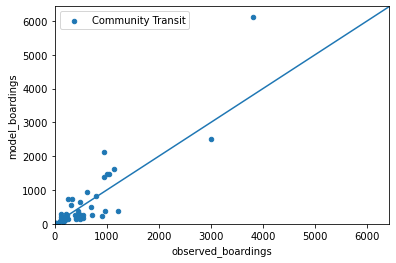

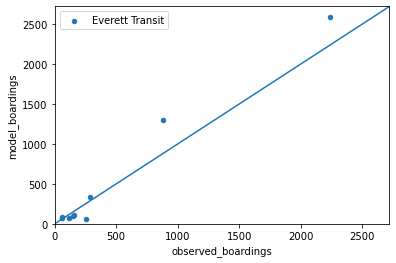

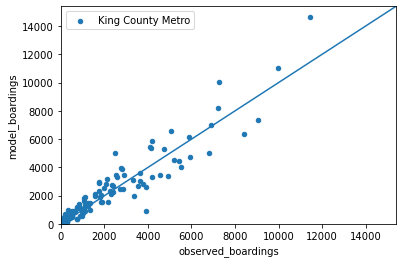

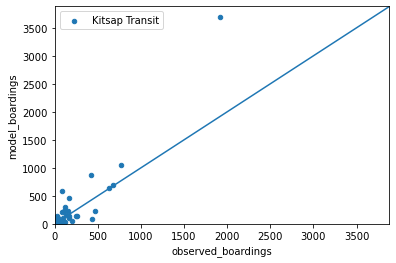

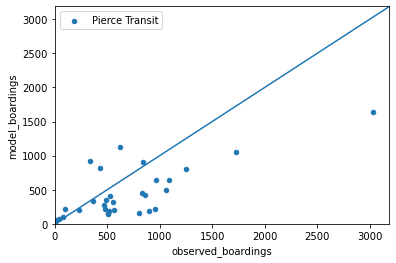

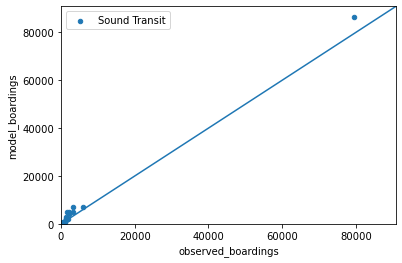

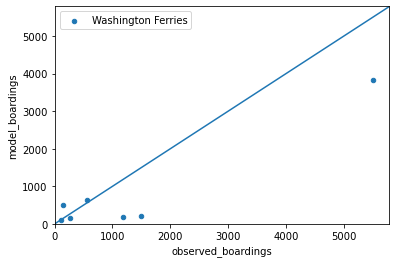

In [137]:
df = pd.read_csv(os.path.join(csv_path,'daily_boardings_by_line.csv'), index_col='agency')
df = df[-df['agency_id'].isnull()]

for agency in np.unique(df.index):
    _df = df.loc[agency,:]
    if (type(_df) == pd.core.frame.DataFrame) & (len(df) > 0):
        ax = _df.plot(kind='scatter', x='observed_boardings', y='model_boardings', label=agency)
        lim = _df[['observed_boardings','model_boardings']].max().max()*1.05
        ax.set_ylim(0,lim)
        ax.set_xlim(0,lim)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x)
        slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed_boardings'],_df['model_boardings'])
        print('r^2 ' + str(agency) + ': ' + str(r_value))

### boarding by light rail station

In [138]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_boardings.csv'), index_col='station_name')
df['diff'] = df['model_boardings']-df['observed_boardings']
df['percent_diff'] = df['diff']/df['observed_boardings']

df_table = df.copy()
df_table[['percent_diff']] = df_table[['percent_diff']].applymap(format_percent)
df_table

line_1_station_list = ['Northgate Station','Roosevelt Station','University District Station', 
                'Husky Stadium', 'Capitol Hill', 'Westlake', 'Symphony', 'Pioneer Square',
                "Int'l District",  'Stadium', 'SODO', 'Beacon Hill',
               'Mount Baker', 'Columbia City', 'Othello', 'Rainier Beach',
                "Tukwila Int'l Blvd", 'SeaTac/Airport', 'Angle Lake']
t_line_station_list = ['Tacoma Dome Station', 'S 25th St Station', 'Union Station',
       'Convention Center Station', 'Commerce Station']

In [139]:
line_1_df = df_table.loc[line_1_station_list]
line_1_df

,observed_boardings,model_boardings,diff,percent_diff
station_name,,,,
Northgate Station,"10,384.00","10,622.17",238.17,2.29%
Roosevelt Station,"4,349.00","8,073.91","3,724.91",85.65%
University District Station,"7,563.00","6,954.08",-608.92,-8.05%
Husky Stadium,"6,134.00","3,551.72","-2,582.28",-42.10%
Capitol Hill,"7,667.00","7,578.60",-88.40,-1.15%
Westlake,"8,845.00","11,554.24","2,709.24",30.63%
Symphony,"4,324.00","6,724.09","2,400.09",55.51%
Pioneer Square,"2,400.00","5,595.17","3,195.17",133.13%
Int'l District,"4,399.00","1,993.23","-2,405.77",-54.69%


In [140]:
fig = px.line(line_1_df[['observed_boardings','model_boardings']])
fig.update_layout(height=500, width=900, font=dict(size=11),
                  yaxis_tickformat = '.00f')
fig.show()

In [141]:
t_line_df = df_table.loc[t_line_station_list]
t_line_df

,observed_boardings,model_boardings,diff,percent_diff
station_name,,,,
Tacoma Dome Station,494.00,280.77,-213.23,-43.16%
S 25th St Station,120.00,396.93,276.93,230.77%
Union Station,420.00,198.59,-221.41,-52.72%
Convention Center Station,91.00,514.63,423.63,465.53%
Commerce Station,294.00,456.36,162.36,55.23%


In [142]:
df_combined = df.copy()

df_combined['station_group'] = df.index
df_combined.loc[['Westlake'],'station_group'] = 'Westlake/Symphony'
df_combined.loc[['Symphony'],'station_group'] = 'Westlake/Symphony'

df_combined.loc[['Pioneer Square'],'station_group'] = "Pioneer Square/Int'l District"
df_combined.loc[["Int'l District"],'station_group'] = "Pioneer Square/Int'l District"

df_combined.loc[['Stadium'],'station_group'] = 'Stadium/SODO'
df_combined.loc[['SODO'],'station_group'] = 'Stadium/SODO'

df_combined.loc[['Beacon Hill'],'station_group'] = 'Beacon Hill/Mount Baker'
df_combined.loc[['Mount Baker'],'station_group'] = 'Beacon Hill/Mount Baker'

df_combined.loc[['Othello'],'station_group'] = 'Othello/Rainier Beach'
df_combined.loc[['Rainier Beach'],'station_group'] = 'Othello/Rainier Beach'

df_combined = df_combined.groupby('station_group').sum()[['observed_boardings','model_boardings']]
df_combined['diff'] = df_combined['model_boardings']-df_combined['observed_boardings']
df_combined['percent_diff'] = df_combined['diff']/df_combined['observed_boardings']
df_combined[['percent_diff']] = df_combined[['percent_diff']].applymap(format_percent)

df_combined = df_combined.loc[['Northgate Station','Roosevelt Station','University District Station', 
                                'Husky Stadium','Capitol Hill','Westlake/Symphony',"Pioneer Square/Int'l District",
                             'Stadium/SODO','Beacon Hill/Mount Baker','Columbia City','Othello/Rainier Beach',
                             "Tukwila Int'l Blvd",'SeaTac/Airport','Angle Lake']]

In [143]:
fig = px.line(df_combined[['observed_boardings','model_boardings']])
fig.update_layout(height=500, width=900, font=dict(size=11),
                  yaxis_tickformat = '.00f')
fig.show()

In [144]:
df_obs = pd.read_sql(
    "SELECT * FROM light_rail_station_boardings WHERE year IN (2023, 2024)",
    con=conn,
)
df_obs.rename(columns={"boardings": "observed_boardings"}, inplace=True)

# df_obs.groupby(['year','station_name']).sum()
df_obs = pd.pivot_table(df_obs, values='observed_boardings', columns='year', index='station_name', aggfunc=np.sum)
df_obs = df_obs.fillna(0)
df_obs

df = pd.read_csv(os.path.join(csv_path,'light_rail_boardings.csv'), index_col='station_name', usecols=['station_name','model_boardings'])
df = df.merge(df_obs,  left_index=True, right_index=True, how='outer')
df = df[df.index != 'Total']
df = df[~df['model_boardings'].isnull()]
df = df.loc[line_1_station_list]

In [145]:
fig = px.line(df[[2023,2024,'model_boardings']])
fig.update_layout(height=500, width=900, font=dict(size=11),
                  yaxis_tickformat = '.00f')
fig.show()

## light rail stop transfers

In [146]:
df = pd.read_csv(os.path.join(csv_path,'light_rail_transfers.csv'), index_col='station_name')
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df.loc[line_1_station_list]

,modeled_transfer_rate,observed_transfer_rate,diff,percent_diff
station_name,,,,
Northgate Station,0.44,-99.00,99.44,-100.44%
Roosevelt Station,0.41,-99.00,99.41,-100.41%
University District Station,0.22,-99.00,99.22,-100.22%
Husky Stadium,0.82,-99.00,99.82,-100.83%
Capitol Hill,0.06,-99.00,99.06,-100.06%
Westlake,0.11,0.36,-0.26,-70.36%
Symphony,0.27,0.20,0.07,34.54%
Pioneer Square,0.36,0.16,0.20,125.02%
Int'l District,0.52,0.45,0.07,14.52%


## Park and Ride

In [147]:
df = pd.read_csv(r'..\..\..\..\outputs\daysim\_trip.tsv', sep='\t')
pnr_boardings = df[(df['otaz'].isin(range(3750,4001))) & (df['mode']==6)]
pnr_boardings = pnr_boardings.groupby('otaz').count()[['trexpfac']].reset_index()

In [148]:
stations = [
    {"id": 3751, "name": "Tukwila Station (CR)"},
    {"id": 3752, "name": "Tacoma Dome Station"},
    {"id": 3753, "name": "South Tacoma (CR)"},
    {"id": 3754, "name": "Everett Station (CR)"},
    {"id": 3755, "name": "Sumner Station (CR)"},
    {"id": 3756, "name": "Mukilteo Station"},
    {"id": 3757, "name": "Kent Station (CR)"},
    {"id": 3758, "name": "Auburn Station (CR)"},
    {"id": 3759, "name": "Lakewood (CR)"},
    {"id": 3760, "name": "Gateway P&R"},
    {"id": 3761, "name": "Puyallup Station (SB)"},
    {"id": 3762, "name": "Twin Lakes P&R"},
    {"id": 3763, "name": "Crossroads Neighborhood Church"},
    {"id": 3764, "name": "Overlake Transit Center"},
    {"id": 3765, "name": "Redondo Heights P&R"},
    {"id": 3766, "name": "North Gig Harbor/Kimball Drive"},
    {"id": 3767, "name": "Duvall P&R"},
    {"id": 3768, "name": "Roy 'Y' P&R"},
    {"id": 3769, "name": "South Hill (Elim Evangelical)"},
    {"id": 3770, "name": "Parkland Transit Center"},
    {"id": 3771, "name": "SR-512/I-5 (Lakewood)"},
    {"id": 3772, "name": "Center Street P&R"},
    {"id": 3773, "name": "Tacoma Mall Transit Center"},
    {"id": 3774, "name": "South Tacoma West"},
    {"id": 3775, "name": "South Tacoma East - 2"},
    {"id": 3776, "name": "Narrows P&R"},
    {"id": 3777, "name": "North Purdy/Purdy Crescent"},
    {"id": 3778, "name": "Point Defiance Ferry"},
    {"id": 3779, "name": "South Federal P&R"},
    {"id": 3780, "name": "Sultan P&R"},
    {"id": 3781, "name": "Federal Way P&R (320th)"},
    {"id": 3782, "name": "Auburn P&R"},
    {"id": 3783, "name": "Star Lake P&R"},
    {"id": 3784, "name": "Holy Spirit Lutheran Church"},
    {"id": 3785, "name": "Kent/Des Moines P&R"},
    {"id": 3786, "name": "Kent/James St. P&R"},
    {"id": 3787, "name": "Burien Transit Center"},
    {"id": 3788, "name": "Tukwila"},
    {"id": 3789, "name": "Maple Valley P&R"},
    {"id": 3790, "name": "South Renton P&R"},
    {"id": 3791, "name": "Renton Highlands P&R (St. Matts)"},
    {"id": 3792, "name": "Issaquah Transit Center"},
    {"id": 3793, "name": "Mercer Island P&R"},
    {"id": 3794, "name": "Mercer Island Presbyterian"},
    {"id": 3795, "name": "Newport Hills P&R"},
    {"id": 3796, "name": "Newport Hills Community Church"},
    {"id": 3797, "name": "Newport Covenant Church"},
    {"id": 3798, "name": "South Bellevue P&R"},
    {"id": 3799, "name": "Wilburton"},
    {"id": 3800, "name": "Eastgate P&R"},
    {"id": 3801, "name": "North Bend P&R"},
    {"id": 3802, "name": "Evergreen Point P&R"},
    {"id": 3803, "name": "Grace Lutheran Church"},
    {"id": 3804, "name": "South Kirkland P&R"},
    {"id": 3805, "name": "Overlake P&R"},
    {"id": 3806, "name": "Houghton P&R"},
    {"id": 3807, "name": "Bethel Lutheran"},
    {"id": 3808, "name": "Redmond P&R"},
    {"id": 3809, "name": "Saint Thomas Episcopal"},
    {"id": 3810, "name": "Valley Center"},
    {"id": 3811, "name": "Bear Creek P&R"},
    {"id": 3812, "name": "Kingsgate P&R"},
    {"id": 3813, "name": "Brickyard P&R"},
    {"id": 3814, "name": "Northshore P&R"},
    {"id": 3815, "name": "Kenmore P&R"},
    {"id": 3816, "name": "Bethany Bible Church"},
    {"id": 3817, "name": "Bothell P&R"},
    {"id": 3818, "name": "Woodinville P&R"},
    {"id": 3819, "name": "Olson & Meyers"},
    {"id": 3820, "name": "Spokane Street P&R"},
    {"id": 3821, "name": "Greenlake P&R"},
    {"id": 3822, "name": "Northgate TC"},
    {"id": 3823, "name": "North Jackson Park"},
    {"id": 3824, "name": "Shoreline"},
    {"id": 3825, "name": "112th St. & I-5"},
    {"id": 3826, "name": "Ober Park"},
    {"id": 3827, "name": "Vashon Heights"},
    {"id": 3828, "name": "Mountlake Terrace P&R"},
    {"id": 3829, "name": "Bethesda Lutheran"},
    {"id": 3830, "name": "Edmonds Station"},
    {"id": 3831, "name": "Edmonds P&R"},
    {"id": 3832, "name": "Lynnwood P&R"},
    {"id": 3833, "name": "Swamp Creek P&R"},
    {"id": 3834, "name": "Mariner P&R"},
    {"id": 3835, "name": "Snohomish"},
    {"id": 3836, "name": "Marysville - Ash Ave"},
    {"id": 3837, "name": "116th & I-5 - Marysville"},
    {"id": 3838, "name": "SR-531 - Marysville"},
    {"id": 3839, "name": "Arlington P&R"},
    {"id": 3840, "name": "Stanwood"},
    {"id": 3841, "name": "Monroe"},
    {"id": 3842, "name": "Federal Way"},
    {"id": 3843, "name": "Port Orchard Armory"},
    {"id": 3844, "name": "Southworth Ferry P&R"},
    {"id": 3845, "name": "McWilliams P&R"},
    {"id": 3846, "name": "Bethany Lutheran Church"},
    {"id": 3847, "name": "Gateway Fellowship"},
    {"id": 3848, "name": "Agate Pass P&R/Clearwater"},
    {"id": 3849, "name": "Kingston Ferry P&R"},
    {"id": 3850, "name": "Suquamish United Church of Christ"},
    {"id": 3851, "name": "Bainbridge Island Ferry"},
    {"id": 3852, "name": "Puyallup Station (NB)"},
    {"id": 3853, "name": "72nd Street Transit Center"},
    {"id": 3855, "name": "DuPont"},
    {"id": 3856, "name": "Aurora Village TC"},
    {"id": 3857, "name": "Aurora Nazarene"},
    {"id": 3858, "name": "Saint Margaret's Episcopal"},
    {"id": 3861, "name": "Lake Meridian P&R"},
    {"id": 3862, "name": "Smokey Pt. Church"},
    {"id": 3863, "name": "Eastmont P&R"},
    {"id": 3864, "name": "McCollum Park P&R"},
    {"id": 3865, "name": "Canyon Park P&R"},
    {"id": 3866, "name": "Korean Presby. P&R"},
    {"id": 3867, "name": "Georges Kountry Korner"},
    {"id": 3868, "name": "Poulsbo Church of the Nazarene"},
    {"id": 3870, "name": "Harper Evangelical Free Church"},
    {"id": 3871, "name": "Mullenix Road"},
    {"id": 3873, "name": "TCC P&R"},
    {"id": 3874, "name": "Ash Way P&R"},
    {"id": 3875, "name": "Bonney Lake P&R"},
    {"id": 3876, "name": "Tukwila Int. Station"},
    {"id": 3877, "name": "South Hill P&R"},
    {"id": 3878, "name": "South Tacoma East - 1"},
    {"id": 3879, "name": "Issaquah Highlands"},
    {"id": 3880, "name": "Lake Stevens TC"},
    {"id": 3881, "name": "Liberty Bay Presbyterian"},
    {"id": 3882, "name": "NK Baptist"},
    {"id": 3883, "name": "Preston P&R"},
    {"id": 3884, "name": "Bayside Community Church"},
    {"id": 3885, "name": "Ollala Valley Fire Station"},
    {"id": 3886, "name": "Bremerton Ferry"},
    {"id": 3888, "name": "Puyallup Fair's Red Lot"},
    {"id": 3889, "name": "Marysville - Cedar & Grove"},
    {"id": 3890, "name": "Stanwood II"},
    {"id": 3891, "name": "Marysville I P&R"},
    {"id": 3892, "name": "Martha Lake Covenant Church"},
    {"id": 3893, "name": "South Sammammish P&R"},
    {"id": 3894, "name": "Renton City Municipal Garage"},
    {"id": 3895, "name": "Tibbetts Lot"},
    {"id": 3896, "name": "Renton Transit Center"},
    {"id": 3897, "name": "Calvary Christian Assembly"},
    {"id": 3898, "name": "Maple Valley Town Square"},
    {"id": 3899, "name": "All Saints Lutheran Church"},
    {"id": 3900, "name": "City View Church"},
    {"id": 3901, "name": "Northwest University 6710 Bldg."},
    {"id": 3902, "name": "Sammamish Lutheran P&R"},
    {"id": 3903, "name": "Redmond Ridge P&R"},
    {"id": 3904, "name": "Kennydale United Methodist Church"},
    {"id": 3905, "name": "Nativity Lutheran Church"},
    {"id": 3906, "name": "South Jackson P&R"},
    {"id": 3907, "name": "South SeaTac (LR)"},
    {"id": 3908, "name": "Everett Station"},
    {"id": 3909, "name": "Bremerton (SR-303/Riddell Road)"},
    {"id": 3910, "name": "Silverdale"},
    {"id": 3911, "name": "Tukwila Station (CR)"},
    {"id": 3913, "name": "Sumner Station Garage"},
    {"id": 3914, "name": "Tacoma Dome"},
    {"id": 3915, "name": "Bothell (SR-527/185th Street)"},
    {"id": 3916, "name": "SR-3/SR-303"},
    {"id": 3917, "name": "SR-16/SR-160"},
    {"id": 3918, "name": "I-5 & 175th"}
]

In [149]:
pnr_capacity = pd.read_csv(r'..\..\..\..\inputs\scenario\networks\p_r_nodes.csv')
df = pnr_capacity.merge(pnr_boardings, left_on='ZoneID', right_on='otaz')
df.rename(columns={'ZoneID': 'taz', 'trexpfac': 'Model Boardings'}, inplace=True)
df['Boardings/Capacity'] = df['Model Boardings']/df['Capacity']
# df.head()

In [150]:
df_station_names = pd.DataFrame(stations)
df = df.merge(df_station_names, how='left', left_on='taz', right_on='id')

In [151]:
df['color'] = np.where(df['Boardings/Capacity'] > 1, 'Boardings/Capacity > 1', 'Boardings/Capacity <= 1')

fig = px.scatter(df, y='Model Boardings', x='Capacity', title='Model Boardings vs Capacity',
                 hover_data={'name': True, 'Model Boardings': True, 'Capacity': True, 'Boardings/Capacity': ':.2f'},
                 color='color')
fig.update_layout(height=600, width=800)
fig.show()

In [153]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.XCoord, df.YCoord), crs='EPSG:2285')
gdf.to_crs('EPSG:4326', inplace=True)

fig = px.scatter_mapbox(gdf, lat=gdf.geometry.y, lon=gdf.geometry.x, color='Boardings/Capacity', 
                        size='Boardings/Capacity', hover_data=['name','taz','Model Boardings', 'Capacity'], 
                        title='Park and Ride Usage vs Capacity', zoom=8)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()